# Imports + config (reproducibility)

In [ ]:
# ===== 0. Imports & global config =====
import os, sys, json, random, math, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

# Reproducibility (so results are repeatable)
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
plt.rcParams["figure.dpi"] = 120

# ===== Update this to match your Kaggle path =====
# Example if you uploaded “A Dataset of Citrus Fruit Images” as a Kaggle dataset:
DATA_ROOT = Path("/kaggle/input/a-dataset-of-citrus-fruit-images/A Dataset of Citrus Fruit Images/CitrusFruit")
ORIG_DIR  = DATA_ROOT / "Original"       # for EDA (true distribution & quality)
AUG_DIR   = DATA_ROOT / "Augmentation"   # for training split (Train-A / Val-A / Test-A)

assert ORIG_DIR.exists(), ORIG_DIR
assert (AUG_DIR / "Train-A").exists(), AUG_DIR
CLASSES = sorted([d.name for d in (AUG_DIR/"Train-A").iterdir() if d.is_dir()])
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES, " | NUM_CLASSES:", NUM_CLASSES)


Classes: ['murcott', 'ponkan', 'tangerine', 'tankan']  | NUM_CLASSES: 4


# 1) EDA class counts (Original) + quick sanity checks

,class,count
0,Test,138
1,Train,966
2,Val,275


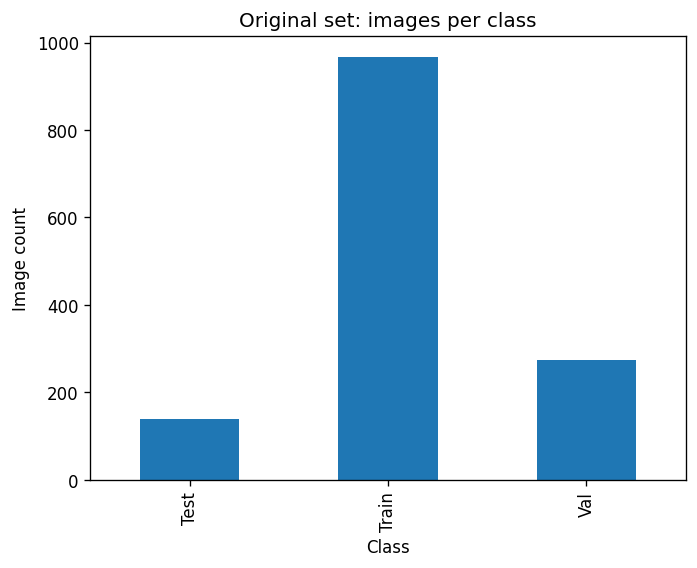

In [9]:
# ===== 1. EDA: class counts on ORIGINAL =====
def count_images(folder: Path):
    rows = []
    for cls in sorted([d for d in folder.iterdir() if d.is_dir()]):
        n = sum(1 for p in cls.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"})
        rows.append({"class": cls.name, "count": n})
    return pd.DataFrame(rows).sort_values("class")

df_orig = count_images(ORIG_DIR)
display(df_orig)

# Bar chart of ORIGINAL distribution
ax = df_orig.plot(kind="bar", x="class", y="count", legend=False, title="Original set: images per class")
ax.set_xlabel("Class"); ax.set_ylabel("Image count"); plt.show()

# 2) EDA check splits (Augmentation/Train‑A, Val‑A, Test‑A)

,split,class,count
0,Train-A,murcott,1176
1,Train-A,ponkan,1380
2,Train-A,tangerine,1680
3,Train-A,tankan,1560
4,Val-A,murcott,336
5,Val-A,ponkan,390
6,Val-A,tangerine,480
7,Val-A,tankan,444
8,Test-A,murcott,28
9,Test-A,ponkan,33


split,Test-A,Train-A,Val-A
class,,,
murcott,28,1176,336
ponkan,33,1380,390
tangerine,40,1680,480
tankan,37,1560,444


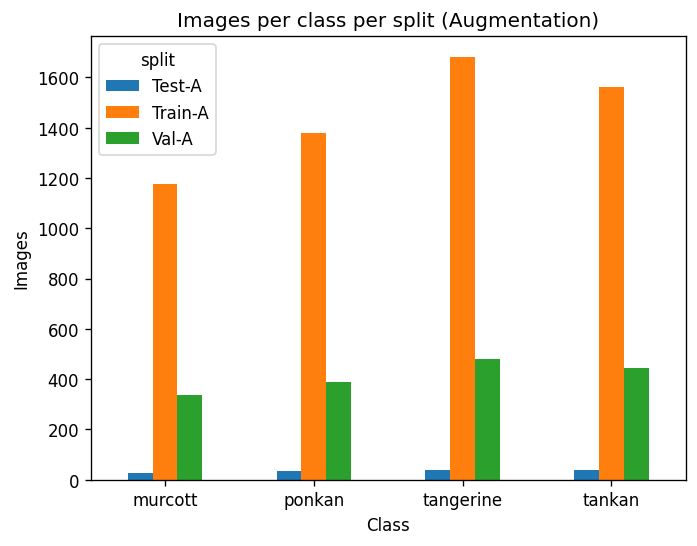

In [10]:
# ===== 2. Split overview: Train-A / Val-A / Test-A =====
def split_counts(base: Path, splits=("Train-A","Val-A","Test-A")):
    frames = []
    for sp in splits:
        root = base / sp
        for cls in CLASSES:
            cnt = sum(1 for p in (root/cls).glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"})
            frames.append({"split": sp, "class": cls, "count": cnt})
    return pd.DataFrame(frames)

df_splits = split_counts(AUG_DIR)
display(df_splits)

# Pivot to plot split-by-class
pivot = df_splits.pivot(index="class", columns="split", values="count").fillna(0).astype(int)
display(pivot)

pivot.plot(kind="bar", title="Images per class per split (Augmentation)")
plt.xlabel("Class"); plt.ylabel("Images"); plt.xticks(rotation=0); plt.show()


# 3) Sample images grid (visual check + label sanity)

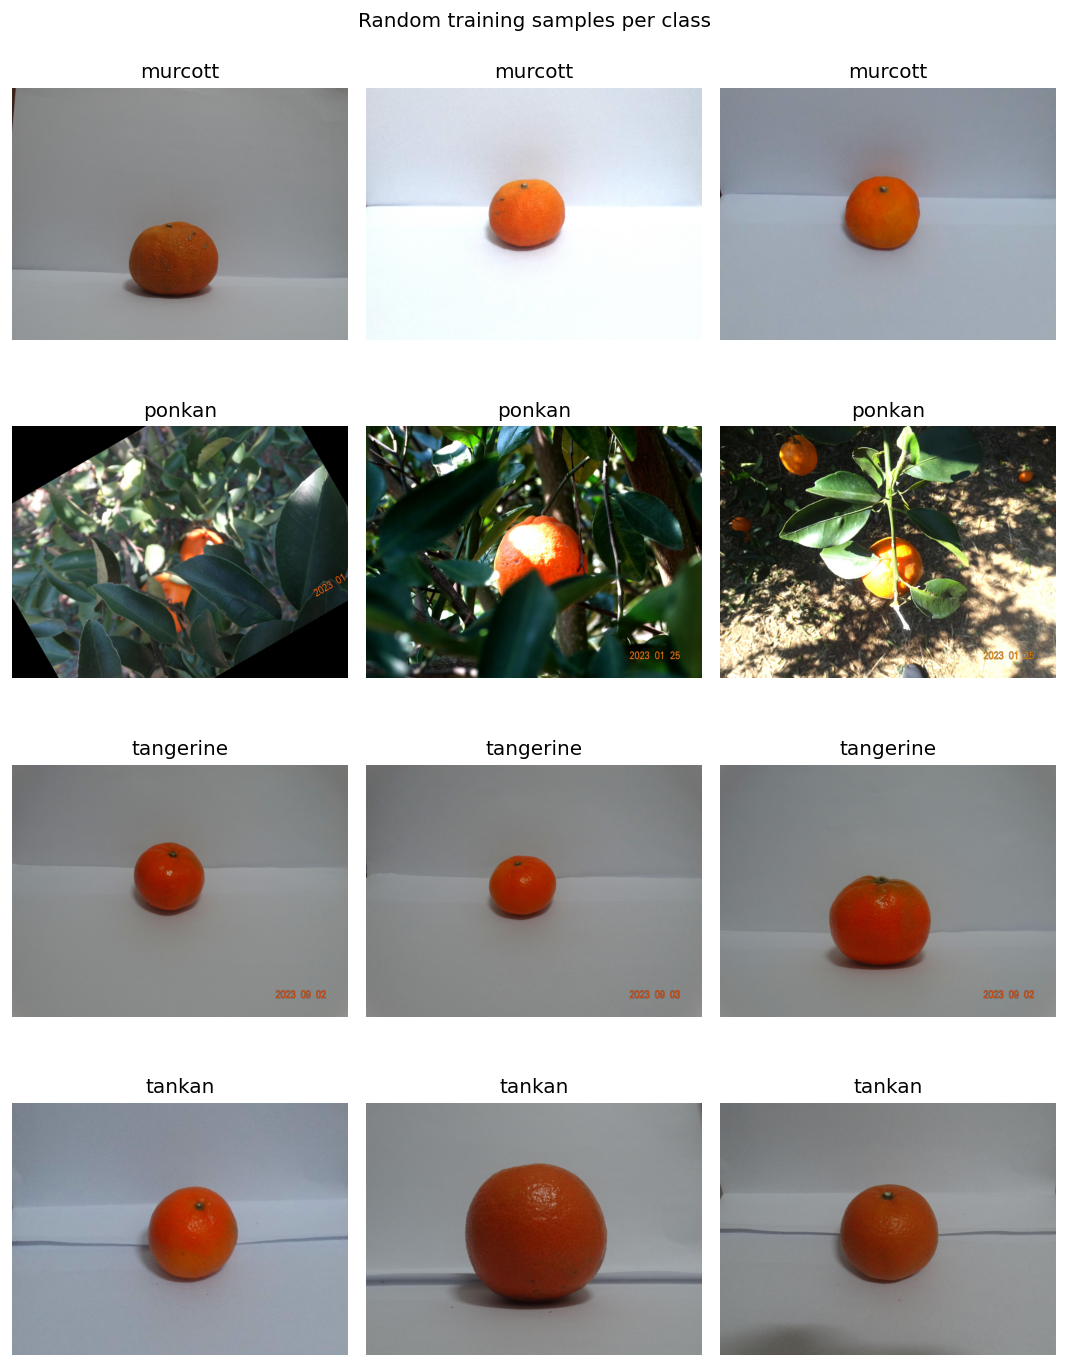

In [11]:
# ===== 3. Visual sanity check (random samples from Train-A) =====
from PIL import Image
import matplotlib.pyplot as plt
import random

N_PER_CLASS = 3
fig, axes = plt.subplots(NUM_CLASSES, N_PER_CLASS, figsize=(N_PER_CLASS*3, NUM_CLASSES*3))
for r, cls in enumerate(CLASSES):
    paths = list((AUG_DIR/"Train-A"/cls).glob("*"))
    samples = random.sample(paths, k=min(N_PER_CLASS, len(paths)))
    for c, p in enumerate(samples):
        img = Image.open(p).convert("RGB")
        axes[r, c].imshow(img); axes[r, c].set_title(cls); axes[r, c].axis("off")
plt.suptitle("Random training samples per class"); plt.tight_layout(); plt.show()


# 4) Image integrity & dimension distribution (quality checks)

Corrupted/unreadable files: 0


,w,h
count,7584.0,7584.0
mean,3648.0,2736.0
std,0.0,0.0
min,3648.0,2736.0
25%,3648.0,2736.0
50%,3648.0,2736.0
75%,3648.0,2736.0
max,3648.0,2736.0


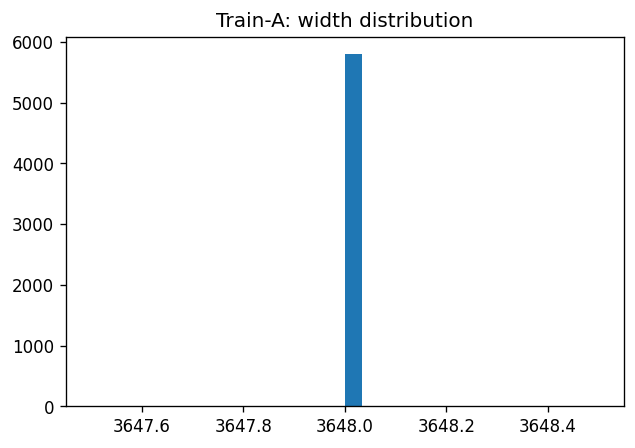

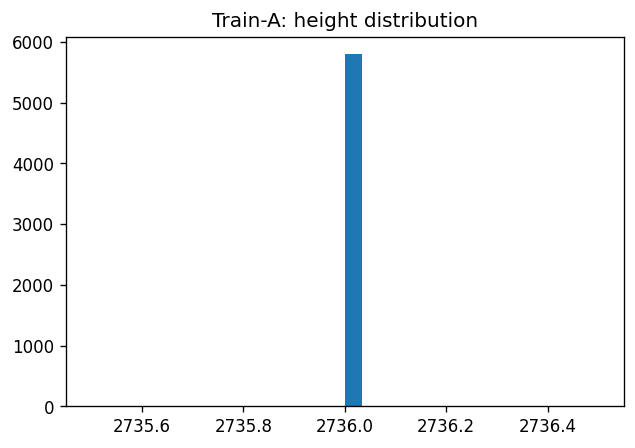

In [12]:
# ===== 4. Quality checks: corrupted files & size distribution =====
bad_files = []
sizes = []

for sp in ["Train-A","Val-A","Test-A"]:
    for cls in CLASSES:
        for p in (AUG_DIR/sp/cls).glob("*"):
            try:
                with Image.open(p) as im:
                    im.verify()  # check integrity
                with Image.open(p) as im:
                    sizes.append({"split": sp, "class": cls, "w": im.width, "h": im.height})
            except (UnidentifiedImageError, OSError):
                bad_files.append(str(p))

print("Corrupted/unreadable files:", len(bad_files))
if bad_files:
    print(bad_files[:10])  # show a few
df_sizes = pd.DataFrame(sizes)
display(df_sizes.describe())

# Plot width/height histogram for Train-A
df_train_sizes = df_sizes[df_sizes["split"]=="Train-A"]
plt.figure(figsize=(6,4)); plt.hist(df_train_sizes["w"], bins=30); plt.title("Train-A: width distribution"); plt.show()
plt.figure(figsize=(6,4)); plt.hist(df_train_sizes["h"], bins=30); plt.title("Train-A: height distribution"); plt.show()


# 5) Define preprocessing & augmentations (Train vs Val/Test)

In [13]:
# ===== 5. Transforms (224x224 is standard for many CNNs) =====
IM_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),          # fruit orientation variance
    transforms.RandomRotation(degrees=15),           # camera angle variance
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),  # lighting variance
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])  # ImageNet stats (works well in practice)
])

eval_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ImageFolder expects: split_dir/class_name/*.jpg
train_ds = datasets.ImageFolder(root=AUG_DIR/"Train-A", transform=train_tfms)
val_ds   = datasets.ImageFolder(root=AUG_DIR/"Val-A",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(root=AUG_DIR/"Test-A",  transform=eval_tfms)

print("Classes mapping (class_to_idx):", train_ds.class_to_idx)
with open("class_to_idx.json","w") as f:
    json.dump(train_ds.class_to_idx, f, indent=2)


Classes mapping (class_to_idx): {'murcott': 0, 'ponkan': 1, 'tangerine': 2, 'tankan': 3}


# 6) DataLoaders (mini‑batches for training loop)

In [14]:
# ===== 6. DataLoaders =====
BATCH_SIZE = 32
NUM_WORKERS = 2  # Kaggle often limits workers; bump if GPU allows

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

for name, dl in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
    n_batches = len(dl)
    n_items   = len(dl.dataset)
    print(f"{name}: {n_items} images | {n_batches} batches of {BATCH_SIZE}")


Train: 5796 images | 182 batches of 32
Val: 1650 images | 52 batches of 32
Test: 138 images | 5 batches of 32


# 7) Visualize “augmentations in action”

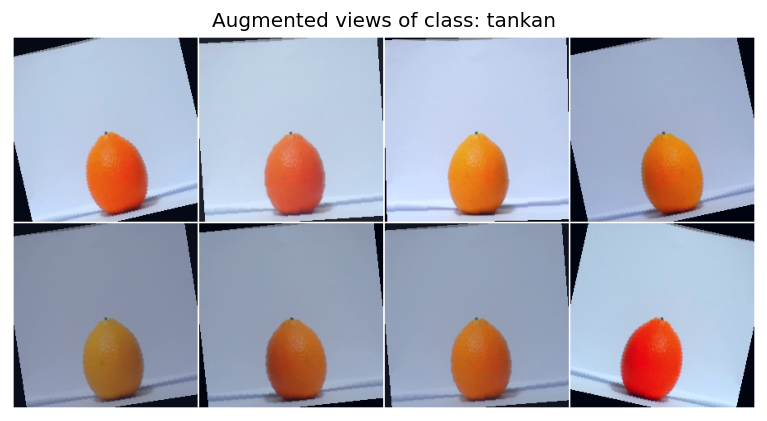

In [15]:
# ===== 7. Show what augmentations do =====
# Take one image and visualize multiple augmented variants
idx = random.randrange(len(train_ds))
img, label = train_ds[idx]  # already augmented once
cls_name = CLASSES[label]

# To show multiple variants, we need raw PIL first, then reapply transform repeatedly
raw_path = (AUG_DIR/"Train-A"/cls_name)
raw_img_path = random.choice(list(raw_path.glob("*")))
raw_pil = Image.open(raw_img_path).convert("RGB")

def apply_tfm(pil, tfm, times=8):
    out = []
    for _ in range(times):
        out.append(tfm(pil))
    return torch.stack(out, dim=0)

samples = apply_tfm(raw_pil, train_tfms, times=8)  # 8 augmented views
grid = vutils.make_grid(samples, nrow=4, normalize=True, pad_value=1.0)
plt.figure(figsize=(8,6)); plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.axis("off")
plt.title(f"Augmented views of class: {cls_name}")
plt.show()


# 8) Stage A summary cell (Key facts)

In [16]:
# ===== 8. Summary to paste into report =====
summary = {
    "classes": CLASSES,
    "num_classes": NUM_CLASSES,
    "original_counts": df_orig.set_index("class")["count"].to_dict(),
    "split_counts": df_splits.to_dict(orient="records"),
    "image_size_used": IM_SIZE,
    "augmentations_train": [
        "Resize(224,224)", "RandomHorizontalFlip(p=0.5)", "RandomRotation(±15°)",
        "ColorJitter(0.2/0.2/0.15/0.05)", "ToTensor()", "Normalize(ImageNet)"
    ],
    "augmentations_val_test": ["Resize(224,224)", "ToTensor()", "Normalize(ImageNet)"],
    "notes": [
        "Original used for EDA; Augmentation split used for training pipeline.",
        "Augmentations chosen to model orientation and lighting variability in citrus imagery.",
        "Val/Test kept augmentation-free for unbiased evaluation."
    ]
}
print(json.dumps(summary, indent=2))


{
  "classes": [
    "murcott",
    "ponkan",
    "tangerine",
    "tankan"
  ],
  "num_classes": 4,
  "original_counts": {
    "Test": 138,
    "Train": 966,
    "Val": 275
  },
  "split_counts": [
    {
      "split": "Train-A",
      "class": "murcott",
      "count": 1176
    },
    {
      "split": "Train-A",
      "class": "ponkan",
      "count": 1380
    },
    {
      "split": "Train-A",
      "class": "tangerine",
      "count": 1680
    },
    {
      "split": "Train-A",
      "class": "tankan",
      "count": 1560
    },
    {
      "split": "Val-A",
      "class": "murcott",
      "count": 336
    },
    {
      "split": "Val-A",
      "class": "ponkan",
      "count": 390
    },
    {
      "split": "Val-A",
      "class": "tangerine",
      "count": 480
    },
    {
      "split": "Val-A",
      "class": "tankan",
      "count": 444
    },
    {
      "split": "Test-A",
      "class": "murcott",
      "count": 28
    },
    {
      "split": "Test-A",
      "class": "ponk